<a href="https://colab.research.google.com/github/bsumanthreddy/DataScientist/blob/main/Model1_Cox_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install --upgrade pip

In [59]:
!pip install progressbar2
!pip install scikit-learn

In [60]:
!pip install pysurvival


  Using cached pysurvival-0.1.2.tar.gz (4.7 MB)
  Preparing metadata (setup.py) ... done
  Using cached progressbar-2.5.tar.gz (10 kB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post9.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pysurvival
  Running setup.py clean for pysurvival
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=67065bec5c59f983741b8e8a3710e28165b53e696f42cfb7946b089ee4929f11
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2952 sha256=873c82d5cb4f6bb2bf1ee9ba406a6f465068ef2f9f1ca060cf9346aacea

In [61]:

!pip install scikit-survival

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis


In [65]:
df=pd.read_csv('/content/predictive_maintenance_dataset.csv')

In [67]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [68]:
# about 125K observations.
df.shape

(124494, 12)

In [69]:
# except for the first two columns, all attributes are integers.
df.dtypes

date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

##Remove Duplicates

In [70]:
df.duplicated().sum()

1

In [71]:
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

In [72]:
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [73]:
# metrics 7 and 8 are identical. Drop one of them.
print('correlation:', df['metric7'].corr(df['metric8']))
print ('Are there any rows where 7!=8?', False in list(df['metric7']==df['metric8']))
df=df.drop('metric8', axis=1)
print(df.shape)

correlation: 1.0
Are there any rows where 7!=8? False
(124494, 11)


In [74]:
#Identifying the unique number of total devices and failure devices in the dataset
total_devices = len(df.device.unique())
print('There are {} total devices'.format(total_devices))

total_failure_devices = len(df[df.failure == 1].device.unique())
print('There are {} total failure devices'.format(total_failure_devices))

There are 1169 total devices
There are 106 total failure devices


In [75]:
print('How many devices have 2 measurements in one day?', df[['device', 'date']].duplicated().sum())
# what is that row?
print(df[df[['device', 'date']].duplicated()==True][['device', 'date']])
df.loc[(df['device']=='S1F0R4Q8') & (df['date']=='2015-07-10')]

How many devices have 2 measurements in one day? 1
          device       date
101335  S1F0R4Q8  7/10/2015


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9


In [76]:
# we should remove one of these duplicate rows.
df=df.drop(df.index[101335], axis=0)
df.reset_index(drop=True)
df.shape

(124493, 11)

In [77]:
# The dates are coded as strings. Replace this.
print(df['date'].dtype)
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)
df['date'].dtype

object


dtype('<M8[ns]')

In [78]:
# metric 1 appears to be an entirely random signal. remove it.
df['metric1'].describe()
df=df.drop('metric1', axis=1)

In [79]:
df.date = pd.to_datetime(df.date)

df['activedays']=df.date-df.date[0]

df['month']=df['date'].dt.month
df['week_day']=df.date.dt.weekday
df['week_day'].replace(0,7,inplace=True)

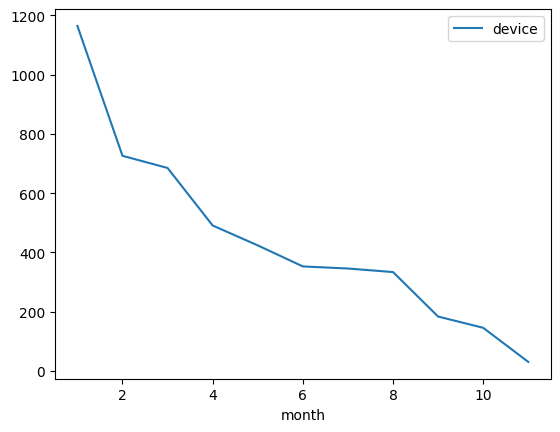

In [80]:
df.groupby('month').agg({'device':lambda x: x.nunique()}).plot()
plt.show()

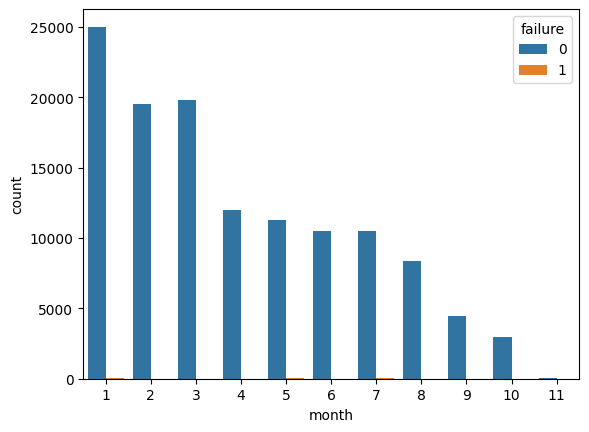

In [81]:
ax = sns.countplot(x="month", hue="failure", data=df)
plt.show()

In [82]:
# what percentage of each is a zero? very high.
def lotsa_zeroes(col):
    numerator=len(df.loc[df[col]==0])
    denominator=len(df[col])
    print(col+':', round(numerator/denominator, 2))
for i in [2, 3,4,7]:
    lotsa_zeroes('metric'+str(i))

metric2: 0.95
metric3: 0.93
metric4: 0.92
metric7: 0.99


#Censoring

In [83]:
# How many unique observations are there for date, device, and overall?
print(df['date'].nunique())
print(df['device'].nunique())
print(len(df))

304
1169
124493


In [84]:

# Do all of devices experience failure? Most do not (but this may be due to censoring).
df.groupby('device').max()['failure'].value_counts()

0    1063
1     106
Name: failure, dtype: int64

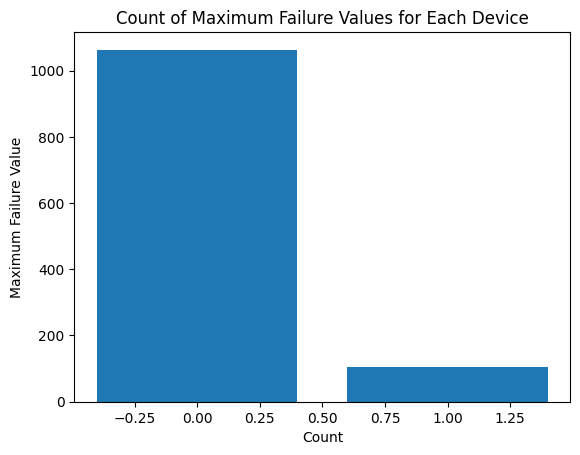

In [120]:
import matplotlib.pyplot as plt

# Calculate counts of maximum 'failure' values for each device
failure_counts = df.groupby('device').max()['failure'].value_counts()

# Create a bar plot
plt.bar(failure_counts.index, failure_counts.values)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Maximum Failure Value')
plt.title('Count of Maximum Failure Values for Each Device')

# Show the plot
plt.show()


In [85]:
# Do any fail multiple times? No. Each device failes only once.
df.groupby('device').sum()['failure'].value_counts()

<ipython-input-85-04212eb706c8>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('device').sum()['failure'].value_counts()


0    1063
1     106
Name: failure, dtype: int64

In [86]:
# confirm that there are no devices with two failure records (each device only fails once)
dffailed=df.loc[df['failure']==1]
assert dffailed['device'].nunique()==dffailed.shape[0]

In [87]:
# restrict to the date on which a device failed.
deaddevice=df[df['failure']==1][['device','date']]

In [88]:
# merge the deathdates back into the regular dataset.
deaddevice = deaddevice.rename(columns={'date': 'deathdate'})
df=pd.merge(df, deaddevice, on='device', how='outer')
df.shape

(124493, 14)

In [89]:
# confirm that, for failed devices, there are no entries later than the failure date.
devices=df.groupby('device').max().reset_index(drop=False)
dead_devices=devices.loc[devices['failure']==1]
dead_devices=dead_devices.rename(columns={'date': 'maxdate'})
dead_devices=dead_devices[['device', 'maxdate', 'deathdate']]
dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]

,device,maxdate,deathdate
101,S1F0GPFZ,2015-07-24,2015-07-12
504,S1F136J0,2015-05-06,2015-05-05
599,W1F0KCP2,2015-05-11,2015-05-09
625,W1F0M35B,2015-05-11,2015-05-09
819,W1F11ZG9,2015-08-17,2015-07-18


In [90]:
# For those 5 devices, remove any dates that occur after the failure.
zombies=dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]['device']
print('Number of rows removed:', df.loc[(df['device'].isin(zombies)) & (df['date']>df['deathdate'])].shape[0])
print(df.shape[0])
df=df.loc[~((df['device'].isin(zombies)) & (df['date']>df['deathdate']))]
print(df.shape[0])
df=df.drop(['deathdate'], axis=1)

Number of rows removed: 47
124493
124446


#Feature engineering by device ID

In [91]:
# What's the first date in the series?
print(df['date'].min())
# Do all devices start on this same date? No.
bydevice=df.groupby('device')['date', 'failure'].min().reset_index(drop=False)
bydevice['date'].value_counts()

2015-01-01 00:00:00


<ipython-input-91-b6a43f308e88>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bydevice=df.groupby('device')['date', 'failure'].min().reset_index(drop=False)


2015-01-01    1163
2015-05-06       4
2015-01-27       1
2015-06-13       1
Name: date, dtype: int64

In [92]:
# creates new dataframe: one row for each device (reduces dimensions from 124K to 1163)
dfmin=df.groupby('device').min().reset_index(drop=False)
# same, but for max values
dfmax=df.groupby('device').max().reset_index(drop=False)

dfmin.head(2)

,device,date,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9,activedays,month,week_day
0,S1F01085,2015-01-01,0,55,0,52,6,407438,0,7,0 days,1,1
1,S1F013BB,2015-05-06,0,0,0,0,5,688952,0,0,125 days,5,2


In [93]:
# which metrics tend to change within a device? all of them.
dfcompare=pd.merge(dfmax, dfmin, on='device', how='left')
dfcompare['metric2_z']=dfcompare['metric2_x']-dfcompare['metric2_y']
dfcompare['metric3_z']=dfcompare['metric3_x']-dfcompare['metric3_y']
dfcompare['metric4_z']=dfcompare['metric4_x']-dfcompare['metric4_y']
dfcompare['metric5_z']=dfcompare['metric5_x']-dfcompare['metric5_y']
dfcompare['metric6_z']=dfcompare['metric6_x']-dfcompare['metric6_y']
dfcompare['metric7_z']=dfcompare['metric7_x']-dfcompare['metric7_y']
dfcompare['metric9_z']=dfcompare['metric9_x']-dfcompare['metric9_y']
for var in ['metric2_z','metric3_z','metric4_z','metric5_z','metric6_z','metric7_z','metric9_z']:
    print(str(var), dfcompare[var].mean())
# this suggests that metrics change, and are an indicator of health.

metric2_z 633.9153122326775
metric3_z 2.270316509837468
metric4_z 6.098374679213003
metric5_z 0.4679213002566296
metric6_z 31298.350727117195
metric7_z 4.076988879384089
metric9_z 60.06415739948674


In [94]:
# just focus on the date for now. Create a column indicating the minimum date, for each device.
dfmin=dfmin[['device', 'date']]
dfmin.rename(columns={'date':'mindate'},inplace=True)
print(dfmin.shape)
dfmin.head()

(1169, 2)


<ipython-input-94-664fcc79e462>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmin.rename(columns={'date':'mindate'},inplace=True)


,device,mindate
0,S1F01085,2015-01-01
1,S1F013BB,2015-05-06
2,S1F0166B,2015-01-01
3,S1F01E6Y,2015-01-01
4,S1F01JE0,2015-01-01


In [95]:
# We can group devices into 7 categories based on their device ID code
dfmin['prefix']=dfmin['device'].apply(lambda row: row[:4])
dfmin['prefix'].value_counts()

<ipython-input-95-fe4b09fc9949>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmin['prefix']=dfmin['device'].apply(lambda row: row[:4])


S1F0    391
W1F0    282
Z1F0    149
S1F1    139
W1F1    138
Z1F1     67
Z1F2      3
Name: prefix, dtype: int64

In [96]:
# merge the groupby-dataset back into primary the dataset
print(df.shape)
df=pd.merge(df, dfmin, on='device', how='left')

(124446, 13)


In [97]:
# create a column to measure elapsed time.
df['timelapse']=(df['date']-df['mindate']).dt.days
df['timelapse'].value_counts()

0      1169
2      1168
1      1168
3      1167
4      1166
       ... 
299      31
301      31
302      31
303      31
305      31
Name: timelapse, Length: 304, dtype: int64

In [98]:
# one-hot encoding of device prefix
ohe=pd.get_dummies(df['prefix'])
df=pd.concat([df, ohe],axis=1)
df.drop(['prefix'],axis=1)
df.head()

,date,device,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9,...,mindate,prefix,timelapse,S1F0,S1F1,W1F0,W1F1,Z1F0,Z1F1,Z1F2
0,2015-01-01,S1F01085,0,55,0,52,6,407438,0,7,...,2015-01-01,S1F0,0,1,0,0,0,0,0,0
1,2015-01-02,S1F01085,0,56,0,52,6,407438,0,7,...,2015-01-01,S1F0,1,1,0,0,0,0,0,0
2,2015-01-03,S1F01085,0,56,0,52,6,407438,0,7,...,2015-01-01,S1F0,2,1,0,0,0,0,0,0
3,2015-01-04,S1F01085,0,56,0,52,6,407439,0,7,...,2015-01-01,S1F0,3,1,0,0,0,0,0,0
4,2015-01-05,S1F01085,0,56,0,52,6,408114,0,7,...,2015-01-01,S1F0,4,1,0,0,0,0,0,0


In [99]:
# What's the longest-lived device that failed?
print(df['timelapse'].max())
df.loc[(df['timelapse']>=280) & (df['failure']==1)]['device'].unique()
T0B1=df.loc[df['device']=='W1F0T0B1']

305


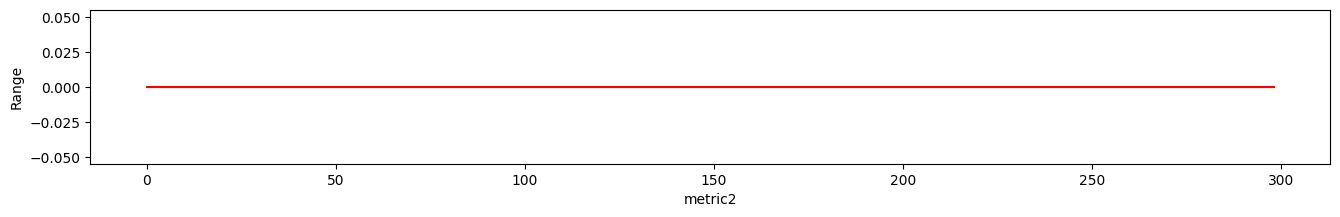

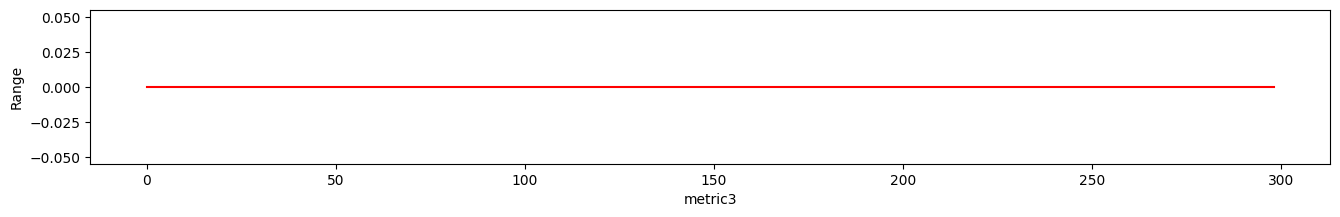

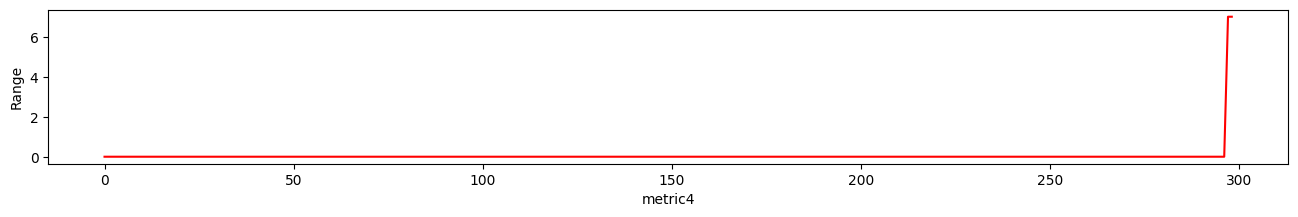

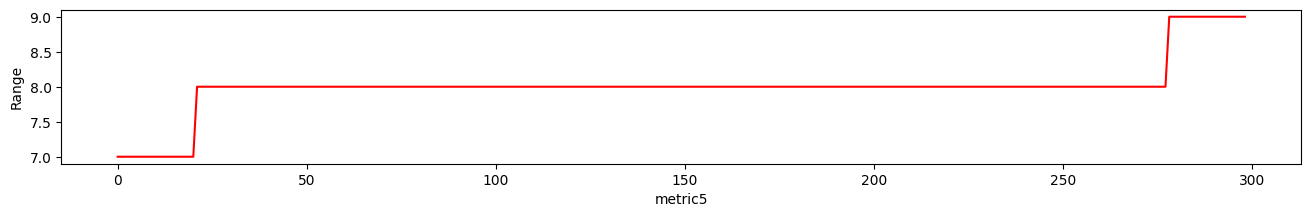

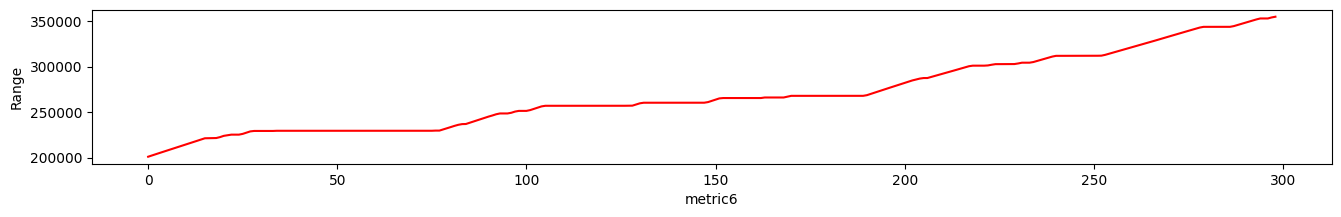

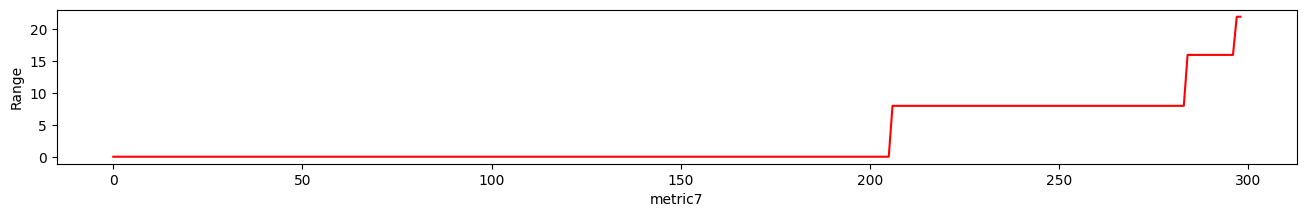

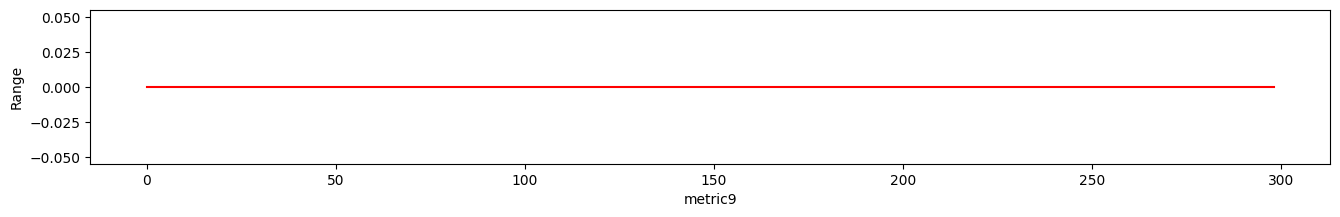

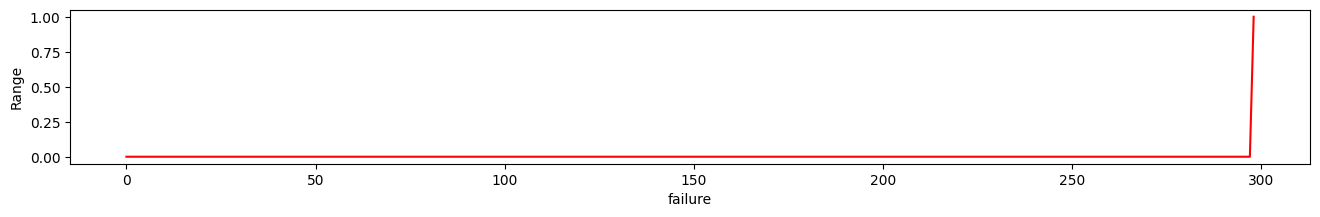

In [100]:
# display the metrics for one device
metrics=['metric2','metric3','metric4','metric5','metric6','metric7','metric9','failure']
for num in range(len(metrics)):
    plt.figure(figsize=(16,2))
    plt.plot(T0B1['timelapse'], T0B1[metrics[num]], color = 'r')
    plt.xlabel(metrics[num])
    plt.ylabel("Range")
    plt.show()

0    228
1     54
2     19
3      2
8      1
Name: failure, dtype: int64


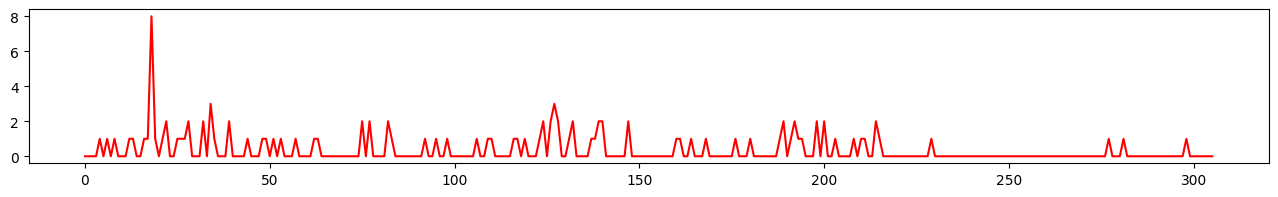

In [101]:
# on any given day, a certain number of devices failed. This is what we want to predict.

timefail=pd.DataFrame(df.groupby('timelapse')['failure'].sum())
print(timefail['failure'].value_counts())
plt.figure(figsize=(16,2))
plt.plot(timefail , color = 'r');

#Modeling:Cox regression analysis

In [102]:
# because metrics tend to vary over time, they're not fixed variables by device.
# device prefix does not vary, and thus serves as an independent variable.
coxdf = df[['device', 'failure', 'prefix', 'timelapse']]
coxdf = coxdf.groupby('device').max()
print(coxdf.shape)
coxdf.tail()

(1169, 3)


,failure,prefix,timelapse
device,,,
Z1F1VMZB,0,Z1F1,291
Z1F1VQFY,1,Z1F1,180
Z1F26YZB,0,Z1F2,83
Z1F282ZV,0,Z1F2,83
Z1F2PBHX,0,Z1F2,95


In [103]:
# one-hot encoding of device prefix
ohe=pd.get_dummies(coxdf['prefix'])
coxdf=pd.concat([coxdf, ohe],axis=1)
coxdf.head()

,failure,prefix,timelapse,S1F0,S1F1,W1F0,W1F1,Z1F0,Z1F1,Z1F2
device,,,,,,,,,,
S1F01085,0,S1F0,5,1,0,0,0,0,0,0
S1F013BB,0,S1F0,5,1,0,0,0,0,0,0
S1F0166B,0,S1F0,5,1,0,0,0,0,0,0
S1F01E6Y,0,S1F0,47,1,0,0,0,0,0,0
S1F01JE0,0,S1F0,5,1,0,0,0,0,0,0


In [104]:
# We drop one category for comparison purposes (intercept)
X=coxdf.drop(['prefix','failure','timelapse','S1F0'],axis=1)
X.columns

Index(['S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2'], dtype='object')

In [105]:
# Convert time & failure into a structured array of booleans
coxdf['failure']=coxdf['failure'].astype('bool')
y=coxdf[['failure','timelapse']].to_records(index=False)
y[:5]

rec.array([(False,  5), (False,  5), (False,  5), (False, 47),
           (False,  5)],
          dtype=[('failure', '?'), ('timelapse', '<i8')])

In [106]:
# Split our data with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [107]:
# Instantiate and fit the estimator
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [108]:
!pip install lifelines

In [109]:
# extract coefficients
pd.Series(estimator.coef_, index=X_train.columns)

S1F1    -0.861759
W1F0     0.234060
W1F1    -0.228673
Z1F0    -0.527990
Z1F1     0.228232
Z1F2   -14.159772
dtype: float64

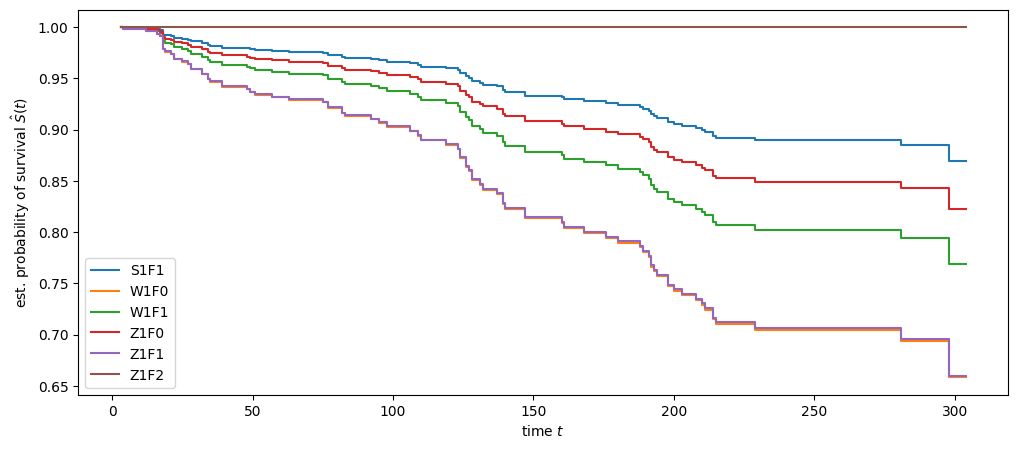

In [110]:
# create 7 new cases
x_new = pd.DataFrame.from_dict({
    1: [1,0,0,0,0,0],
    2: [0,1,0,0,0,0],
    3: [0,0,1,0,0,0],
    4: [0,0,0,1,0,0],
    5: [0,0,0,0,1,0],
    6: [0,0,0,0,0,1]
},
     columns=X_train.columns, orient='index')

# list the device categories
device_types=list(X_train.columns)
# display as curves
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(3, 305)
plt.figure(figsize=(12,5))
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label=device_types[i])
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

#Evaluation of Cox Regression

In [111]:
# Measuring the Performance of the Survival Model
print(estimator.score(X_train,y_train))
cox_reg_score=estimator.score(X_test,y_test)
print(cox_reg_score)

0.5963666100118654
0.5852956567242281


In [113]:
survival_probabilities = estimator.predict_survival_function(X_test)
survival_probabilities

array([StepFunction(x=array([  2,   4,   5,   6,  12,  16,  17,  18,  19,  21,  22,  25,  27,
               28,  32,  34,  35,  39,  47,  48,  49,  51,  54,  57,  63,  75,
               76,  77,  81,  82,  83,  85,  92,  95,  96,  98, 105, 106, 109,
              110, 119, 123, 124, 126, 127, 128, 130, 131, 132, 137, 139, 140,
              141, 147, 160, 161, 168, 176, 180, 188, 189, 191, 192, 193, 194,
              198, 200, 203, 208, 210, 211, 214, 215, 223, 224, 225, 229, 231,
              235, 239, 244, 258, 272, 277, 281, 284, 286, 291, 294, 298, 305]), y=array([1.        , 0.9983506 , 0.9983506 , 0.9983506 , 0.99594875,
              0.9934794 , 0.99101005, 0.97873103, 0.976269  , 0.97380826,
              0.968893  , 0.96643225, 0.9639728 , 0.95906018, 0.95416426,
              0.94926834, 0.94682058, 0.94193812, 0.94193812, 0.9393775 ,
              0.93681833, 0.93426289, 0.93426289, 0.93170418, 0.92914693,
              0.92658973, 0.92658973, 0.92145704, 0.92145704, 0.9

##saving the model

In [115]:
import joblib

# Assuming you have already fitted your CoxPHSurvivalAnalysis estimator and named it 'estimator'
model_filename = 'cox_model.pkl'

# Serialize and save the trained model
joblib.dump(estimator, model_filename)


['cox_model.pkl']

In [116]:
import joblib

# Load the serialized model
loaded_estimator = joblib.load(model_filename)

# Now you can use 'loaded_estimator' for predictions or analysis
